In [5]:
!python3 idk.py \
    --dapi 'A1ROI1_02_2_1Z4_Confocal DAPI_001.tif' \
    --data 'data' \
    --plot

A1ROI1_02_2_1Z4_Confocal DAPI_001.tif A1ROI1_02_3_1Z4_Confocal GFP_001.tif A1ROI1_02_4_1Z4_Confocal TRITC_001.tif

Analysing: A1ROI1, Z4
Step 1: Preprocessing DAPI image...
Step 2: Finding contours...
  Found 4 clusters
Figure(2000x1000)
Step 3: Building GFP and TRITC histograms for clusters...
Step 4: Saving histograms

Saving histogram data for ROI: A1ROI1
  Successfully saved GFP histogram data to out/A1ROI1_GFP.csv
  Successfully saved TRITC histogram data to out/A1ROI1_TRITC.csv
---------------------------------------

Done :D


In [2]:
import copy
import os
import glob

import cv2
import numpy as np
import pandas as pd
from cv2.typing import MatLike
from matplotlib import pyplot as plt
import re

In [3]:
DATA_DIR = "data"
OUTPUT_DIR = "out"
os.makedirs(OUTPUT_DIR, exist_ok=True)

PLOT = True

In [ ]:
def preprocess(gray: MatLike):
    """
    Preprocesses a grayscale image to create a binary mask for cell segmentation.
    """
    # apply Otsu's thresholding
    # might not be the best, as the intensities sometimes look overtuned
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

    # apply morphological opening to remove small objects and noise
    # while preserving the shape of larger objects (cell clusters)
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(13, 13))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(7, 7))
    mask = cv2.dilate(mask, kernel, iterations=2)

    # plt.imshow(mask, cmap='gray')
    # plt.axis('off')

    return mask


def plot_contours(dapi: MatLike, gfp: MatLike, tritc: MatLike, contours: list[MatLike], roi_name: str=""):
    # copy to avoid modifying original images
    segmented_img = copy.deepcopy(dapi)
    target_img = copy.deepcopy(gfp)
    target_img2 = copy.deepcopy(tritc)
    
    for i, contour in enumerate(contours):
        # draw contour on all three images
        colour = (0, 255, 0)
        cv2.drawContours(segmented_img, contours, i, colour, 3)
        cv2.drawContours(target_img, contours, i, colour, 3)
        cv2.drawContours(target_img2, contours, i, colour, 3)

        text = str(i+1)
        # print()
        cv2.putText(segmented_img, text, tuple(contour[0][0]), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 255), 10, cv2.LINE_AA)
        cv2.putText(target_img, text, tuple(contour[0][0]), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 255), 10, cv2.LINE_AA)
        cv2.putText(target_img2, text, tuple(contour[0][0]), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 255), 10, cv2.LINE_AA)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    fig.canvas.manager.set_window_title(roi_name)
    ax1.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
    ax1.set_title("DAPI")
    ax1.axis("off")
    ax2.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
    ax2.set_title("GFP")
    ax2.axis("off")
    ax3.imshow(cv2.cvtColor(target_img2, cv2.COLOR_BGR2RGB))
    ax3.set_title("TRITC")
    ax3.axis("off")
    plt.tight_layout(rect=(0.0, 0.03, 1.0, 0.95))
    plt.show()

    return fig



def find_contours(mask: MatLike):
    """
    Identifies and visualizes cellular clusters by finding contours in the mask image.
    """

    # find contours around the cell clusters
    contours, h = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    n = 0
    cluster_contours: list[MatLike] = []

    all_areas = [cv2.contourArea(c) for c in contours]
    # min_area_percentile = 98.0
    # contour_threshold = np.percentile(all_areas, min_area_percentile)
    contour_threshold = 3000

    # process each contour, filtering by area
    for i, contour in enumerate(contours):
        area = all_areas[i]
        if area > contour_threshold:
            cluster_contours.append(contour)
            n += 1

    print(f"  Found {n} clusters")

    return cluster_contours


def save_histogram(channel_histograms, roi_name):
    print(f"\nSaving histogram data for ROI: {roi_name}")
 
    for channel_name, ch_data in channel_histograms.items():
        data_dict = {}
        for zoom_level, zoom_data in ch_data.items():
            data_dict[zoom_level] = pd.DataFrame(zoom_data)
        
        output_filename = os.path.join(OUTPUT_DIR, f"{roi_name}_{channel_name}.csv")
        try:
            final_df = pd.concat(data_dict, axis=1)
            final_df.to_csv(output_filename, index=False)
            # final_df.to_excel(output_filename)
            print(
                f"  Successfully saved {channel_name} histogram data to {output_filename}"
            )
        except Exception as e:
            print(
                f"  Error saving CSV file for {channel_name} to {output_filename}: {e}"
            )


def build_histogram(channels: dict[str, MatLike], contours: list[MatLike], zoom: str, channel_histograms=None):
    """
    Calculates pixel intensity histograms for each cluster
    and saves the results to CSV files.
    """
    num_bins = 256
    bin_edges = np.arange(num_bins + 1)

    # nested dictionary that stores histogram data for each channel
    # {'ChannelName': {'Z4' : {'Cluster_0': counts_array, 'Cluster_1': counts_array, ...}, {'Z6': {'Cluster_0': counts_array, 'Cluster_1': counts_array, ...}}}} 
    for name in channel_histograms.keys():
        channel_histograms[name][zoom] = {}
    # print(channel_histograms)

    # iterate over each cluster
    for i, cluster in enumerate(contours):
        # binary mask for the current cluster
        cluster_map = np.zeros_like(channels['GFP'], dtype=np.uint8)
        cv2.drawContours(cluster_map, [cluster], 0, [255.0], thickness=cv2.FILLED)

        # boolean mask for pixel selection
        mask_boolean = cluster_map > 0

        # iterate over each grayscale image
        for channel_name, gray_image in channels.items():
            # select pixels from the current grayscale image that fall within the cluster mask
            pixels_inside_contour = gray_image[mask_boolean]

            # calculate histogram
            if pixels_inside_contour.size > 0:
                histogram_counts, _ = np.histogram(
                    pixels_inside_contour, bins=bin_edges
                )
                # print(histogram_counts)
                column_name = f"Cluster_{i+1}"
                channel_histograms[channel_name][zoom][column_name] = histogram_counts
    
    return channel_histograms

In [ ]:
def parse_path(dapi_path: str):
    pattern = re.compile(r"^(.*_)(\d)(_\d(.*)_Confocal )([A-Z]+)(_.*\.tif)$")
    match = pattern.match(dapi_path)

    if match:
        prefix = match.group(1)
        middle = match.group(3)
        zoom = match.group(4)
        suffix = match.group(6)
        # print(prefix, middle, zoom, suffix)
        
        gfp_path = f"{prefix}3{middle}GFP{suffix}"
        tritc_path = f"{prefix}4{middle}TRITC{suffix}"

    else:
        print(f"Error: The input path '{dapi_path}' does not match the expected pattern.")
        return 
    
    print(dapi_path, gfp_path, tritc_path)
    out_name = prefix.split("_")[0]

    return gfp_path, tritc_path, out_name, zoom


def load_data(dapi_path: str, gfp_path: str, tritc_path: str):
    dapi = cv2.imread(os.path.join(DATA_DIR, dapi_path))
    dapi_gray = cv2.cvtColor(dapi, cv2.COLOR_BGR2GRAY)
    # print(dapi_gray.shape, dapi_gray.dtype)

    gfp = cv2.imread(os.path.join(DATA_DIR, gfp_path))
    gfp_gray = cv2.cvtColor(gfp, cv2.COLOR_BGR2GRAY)

    tritc = cv2.imread(os.path.join(DATA_DIR, tritc_path))
    tritc_gray = cv2.cvtColor(tritc, cv2.COLOR_BGR2GRAY)

    imgs = {
        'dapi': {
            'img': dapi,
            'gray': dapi_gray
        },
        'gfp': {
            'img': gfp,
            'gray': gfp_gray
        },
        'tritc': {
            'img': tritc,
            'gray': tritc_gray
        }
    }

    return imgs

def additional_images(zoom: str, dapi_path: str, clusters, channel_histogramsan):
    pattern = re.compile(r"^(.*_)(\d)(_\d(.*)_Confocal )([A-Z]+)(_.*\.tif)$")
    match = pattern.match(dapi_path)
    prefix = match.group(1)
    suffix = match.group(6)

    print('Repeating for: ', zoom)
    dapi_path = f"{prefix}2_1{zoom}_Confocal DAPI{suffix}"
    gfp_path = f"{prefix}3_1{zoom}_Confocal GFP{suffix}"
    tritc_path = f"{prefix}4_1{zoom}_Confocal TRITC{suffix}"
    
    print(dapi_path, gfp_path, tritc_path)

    dapi = cv2.imread(os.path.join(DATA_DIR, dapi_path))
    dapi_gray = cv2.cvtColor(dapi, cv2.COLOR_BGR2GRAY)
    # print(dapi_gray.shape, dapi_gray.dtype)

    gfp = cv2.imread(os.path.join(DATA_DIR, gfp_path))
    gfp_gray = cv2.cvtColor(gfp, cv2.COLOR_BGR2GRAY)

    tritc = cv2.imread(os.path.join(DATA_DIR, tritc_path))
    tritc_gray = cv2.cvtColor(tritc, cv2.COLOR_BGR2GRAY)

    plot_contours(dapi, gfp, tritc, clusters, 'aaa')

    channels = {"GFP": gfp_gray, "TRITC": tritc_gray}
    # channel_histograms = build_histogram(channels, clusters, zoom, channel_histograms)
    # return channel_histograms

    return channels


A1ROI1_02_2_1Z6_Confocal DAPI_001.tif A1ROI1_02_3_1Z6_Confocal GFP_001.tif A1ROI1_02_4_1Z6_Confocal TRITC_001.tif

Analysing: A1ROI1, Z6
Step 1: Preprocessing DAPI image...
Step 2: Finding contours...
  Found 5 clusters


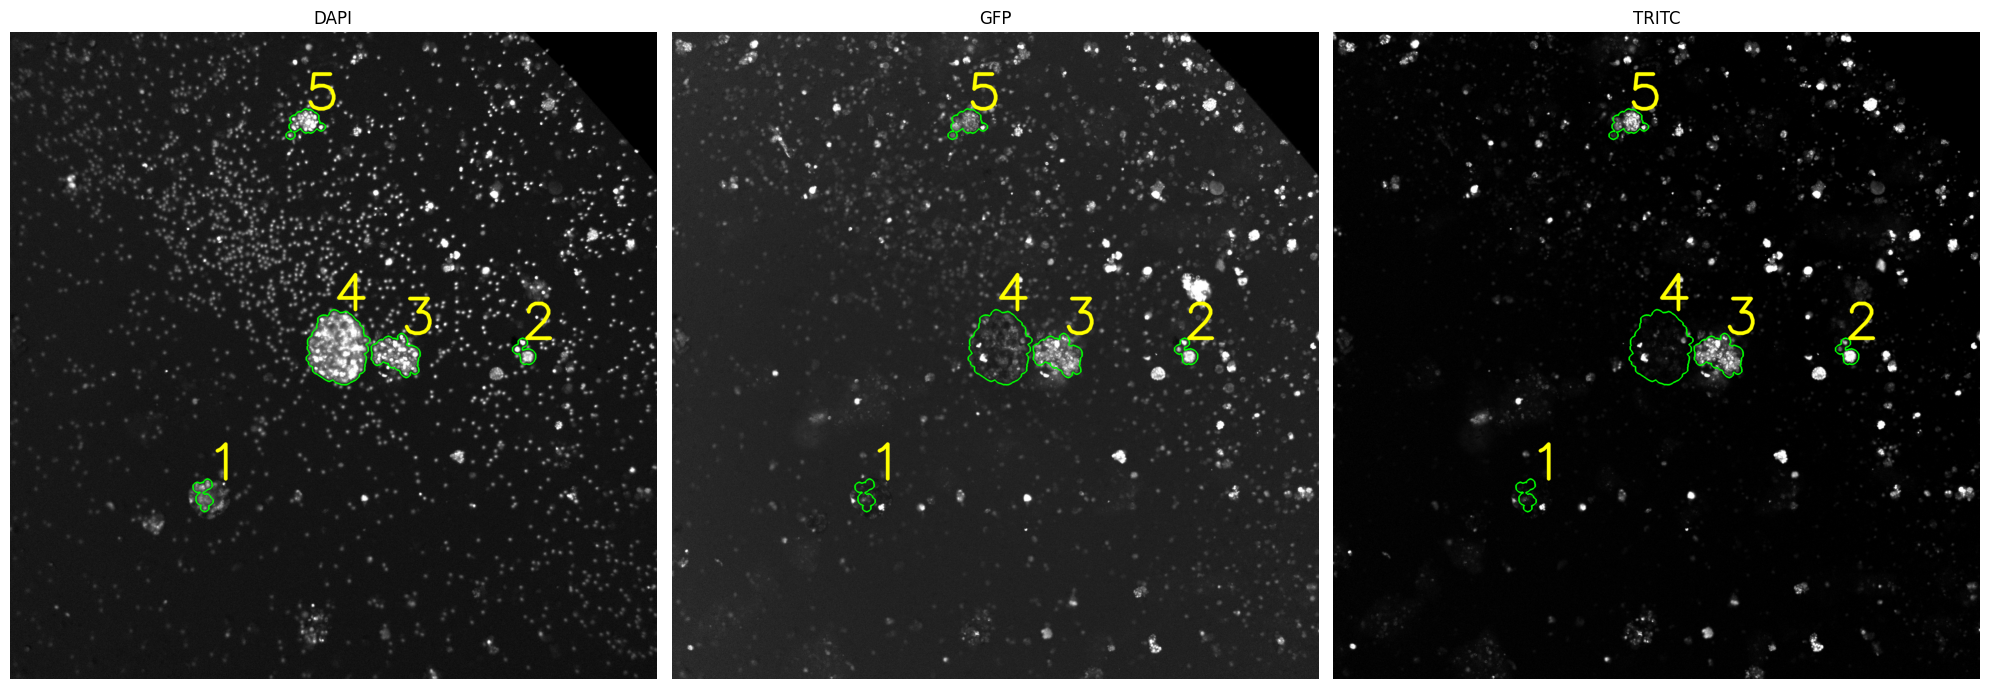

Step 3: Building GFP and TRITC histograms for clusters...


In [ ]:
dapi_path = 'A1ROI1_02_2_1Z6_Confocal DAPI_001.tif'

gfp_path, tritc_path, out_name, zoom = parse_path(dapi_path)
imgs = load_data(dapi_path, gfp_path, tritc_path)

print(f"\nAnalysing: {out_name}, {zoom}")

print("Step 1: Preprocessing DAPI image...")
mask = preprocess(imgs['dapi']['gray'])

print("Step 2: Finding contours...")
clusters = find_contours(mask)

figure = None
if PLOT:
    figure = plot_contours(imgs['dapi']['img'], imgs['gfp']['img'], imgs['tritc']['img'], clusters)

print("Step 3: Building GFP and TRITC histograms for clusters...")
channels = {"GFP": imgs['gfp']['gray'], "TRITC": imgs['tritc']['gray']}
channel_histograms = {"GFP": {}, "TRITC": {}}

channel_histograms = build_histogram(channels, clusters, zoom, channel_histograms)

Step 5: Repeat for additional zooms...
Repeating for:  Z6
A1ROI1_02_2_1Z6_Confocal DAPI_001.tif A1ROI1_02_3_1Z6_Confocal GFP_001.tif A1ROI1_02_4_1Z6_Confocal TRITC_001.tif


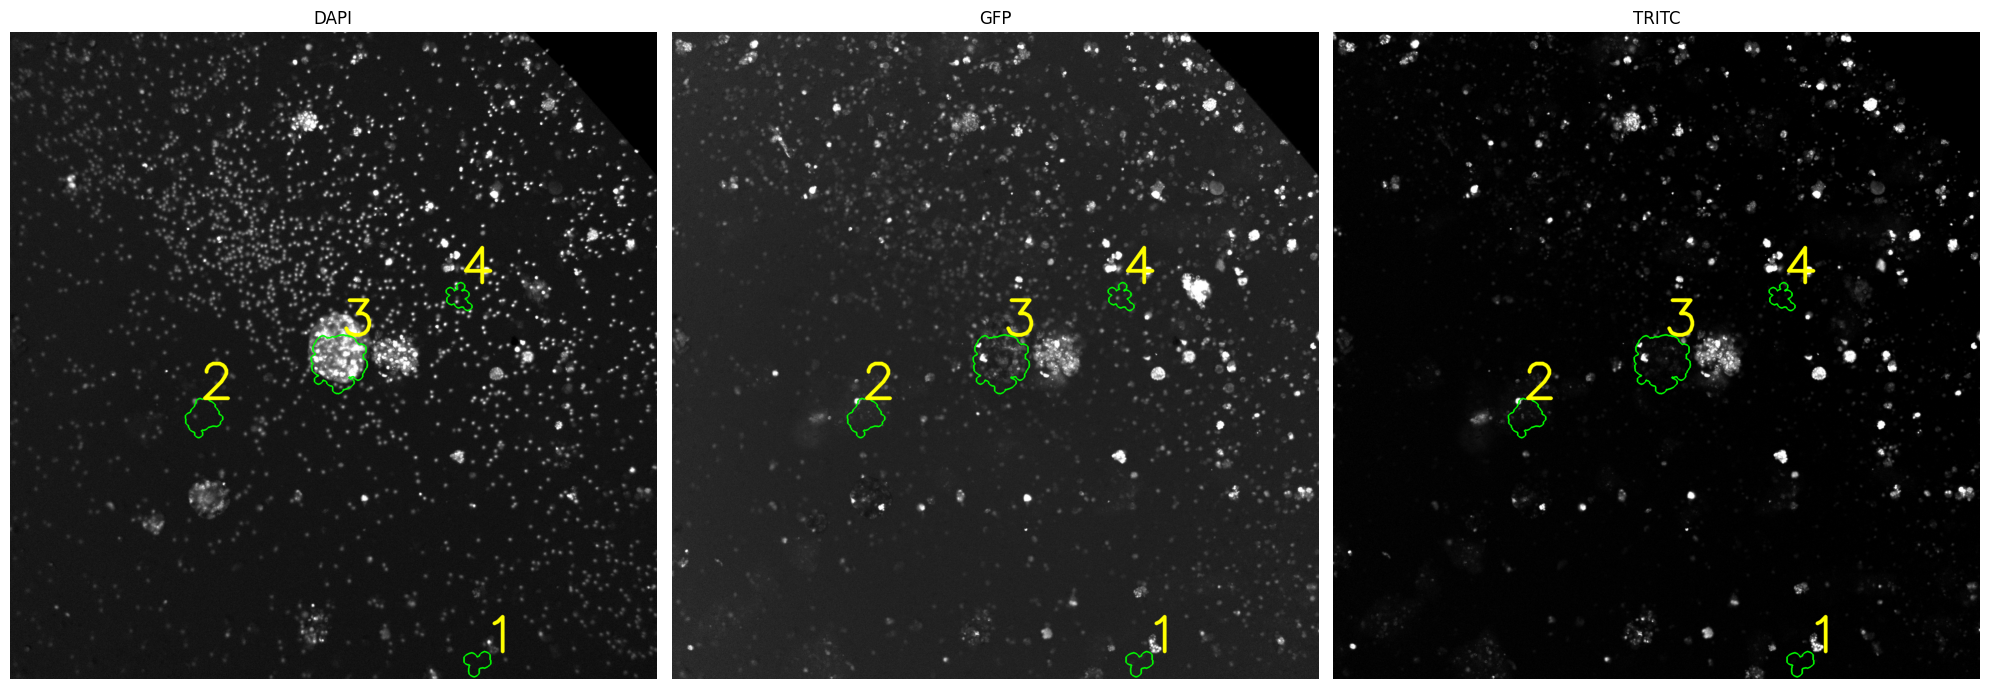

In [ ]:
print("Step 4: Repeat for additional zooms...")
zoom = "Z6"
channels = additional_images(zoom, dapi_path, clusters, channel_histograms)
channel_histograms = build_histogram(channels, clusters, zoom, channel_histograms)

In [ ]:
print("Step 5: Saving histograms")
save_histogram(channel_histograms, out_name)
if figure:
    figure.savefig(os.path.join(OUTPUT_DIR, out_name+'.png'))

print("\nDone :D")

Step 6: Saving histograms

Saving histogram data for ROI: A1ROI1
  Successfully saved GFP histogram data to out/A1ROI1_GFP.csv
  Successfully saved TRITC histogram data to out/A1ROI1_TRITC.csv

Done :D
